# **Part 4 -- The keywords data**

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import re
import nltk
import missingno as msno
from tqdm import tqdm
import json
import statistics
import math

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from gensim.models import Phrases
from collections import Counter

# enabling Jupyter Lab to include the output of our plots directly in this notebook
%matplotlib inline


# used to avoid blurry output plots in Jupyter Notebooks
%config InLineBackend.figure_format = "retina"

pd.options.mode.chained_assignment = None

THE DATASET

This dataset contain information for keywords about all the papers published from the first of January 2012 to the 31st of December 2022 related to our list of concepts. 

More specifically, the dataset contains the following information for each paper:
- ```paper```: the URL link of the internet page for each paper created by OpenAlex. All information about the paper are given on this internet page.
- ```keyword```: the keyword related to the paper, computed using the title and the abstract of the paper and algorithm named 'keybert'. The keyword are not always words, since we only take the root of each word not distinguishing two words like 'friend' and 'friendly' for example.
- ```cosine_similarity	```: score of attribution between 0 and 1 of a keyword to the text (composed of the title and the abstract of the paper) which shows how close is a keyword to a text.
- ```publication_date```: the date of publication of the paper
- ```year```: the year of publication of the paper
- ```month```: the month of publication of the paper

__Downloading the data__

In [2]:
infile_dfkeywords = open('../creation_data_and_variables/data_creation_variables/dfkeywords','rb')
dfkeywords = pickle.load(infile_dfkeywords)
infile_dfkeywords.close()

<div class="alert-info">
1. Visualization of the daframe and basic statistics
</div>

In [3]:
dfkeywords

,paper,keyword,cosine_similarity,publication_date,year,month
0,https://openalex.org/W2885223756,blockchain,0.4387,2018-08-16,2018,August
0,https://openalex.org/W2885223756,slave,0.3483,2018-08-16,2018,August
0,https://openalex.org/W2885223756,comput,0.3407,2018-08-16,2018,August
0,https://openalex.org/W2885223756,mobil,0.334,2018-08-16,2018,August
0,https://openalex.org/W2885223756,slaveri,0.3331,2018-08-16,2018,August
...,...,...,...,...,...,...
135447,https://openalex.org/W4214588288,neural,0.3529,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synthet,0.3373,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synthesi,0.3073,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synfac,0.3009,2021-10-01,2021,October


In [4]:
dfkeywords['cosine_similarity'].describe()

count     675294.0000
unique      6112.0000
top            0.3004
freq         458.0000
Name: cosine_similarity, dtype: float64

In [5]:
len(dfkeywords.paper.tolist())/5

135058.8

In [6]:
len(list(set(dfkeywords.paper.tolist())))

135448

We see that not every paper has 5 keywords, since the number of papers divided by 5 is less than the number of papers overall. But there are very few papers with less than 5 keywords.

<div class="alert-info">
2. We check the data type for each column.
</div>

In [7]:
dfkeywords.dtypes

paper                object
keyword              object
cosine_similarity    object
publication_date     object
year                  int64
month                object
dtype: object

<div class="alert-info">
3. Checking the duplicates
</div>

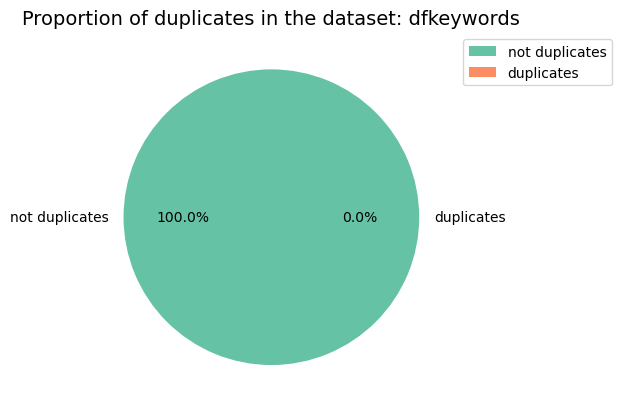

In [8]:
# little fancy visualization for dfkeywords

dfkeywords_noduplicates = dfkeywords.drop_duplicates()

# data to be displayed
data = [len(dfkeywords_noduplicates), len(dfkeywords) - len(dfkeywords_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: dfkeywords",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

__Observation__ 

As expected there are no duplicates in my dataset. In fact, this is how I constructed this dataset.

<div class="alert-info">
4. We show the proportion of missing values in the data.
</div>

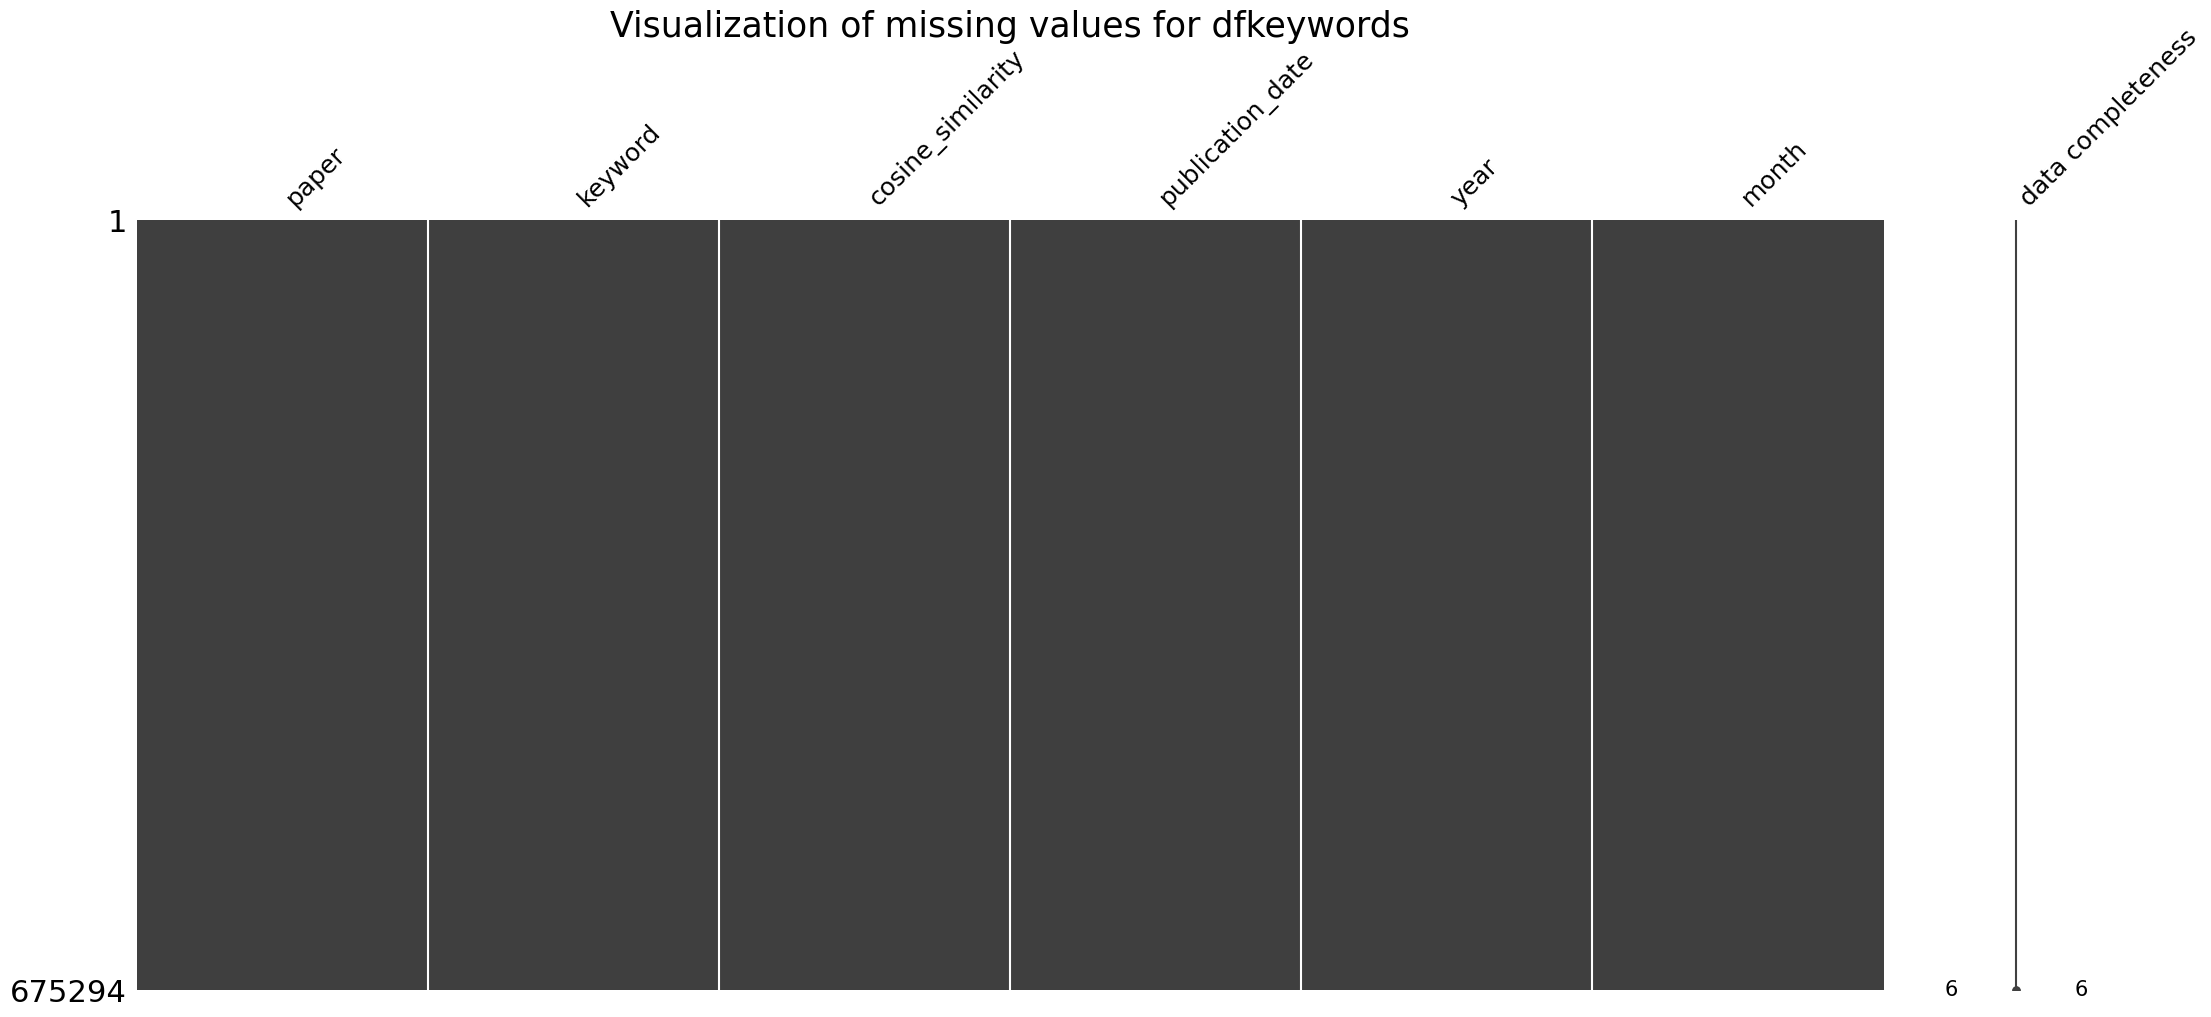

In [9]:
msno.matrix(dfkeywords,labels=True, fontsize=18)
plt.title("Visualization of missing values for dfkeywords",fontsize = 25)
plt.show()

__Observation__ 

As expected there are no missing values in my dataset. In fact this is how I constructed this dataset.

<div class="alert-info">
5. Checking unique values
</div>

In [10]:
unique_values = dfkeywords.select_dtypes(include=["object",'int64']).nunique()
unique_values

paper                135448
keyword               31460
cosine_similarity      6112
publication_date       6669
year                     21
month                    12
dtype: int64

We see that there is a very important number of unique keywords. Probably, many of them are not really relevant and we should eliminate or filter some of them. In fact, later in the keyword analysis, we will see that the keywords that occur only once tend to be weird and even useless, since then we cannot create a link based on 'common' keywords.

Downloading data to visualize and show information about keywords.

<div class="alert-info">
6. Downloading and analyzing some auxiliary dataframe
</div> 

We do quite quickly the procedure of checking our dataframes for two auxiliary dataset we created.

__Quick analysis of dfkeywords_importance__

In [11]:
infile_keywords_importance = open('../creation_data_and_variables/data_creation_variables/dfkeywords_importance','rb')
dfkeywords_importance = pickle.load(infile_keywords_importance)
infile_keywords_importance.close()

THE DATASET

This dataset contain information for keywords about all the keywords computed from all the papers published from the first of January 2012 to the 31st of December 2022 related to our list of concepts. 

More specifically, the dataset contains the following information for each paper:
- ```keyword```: the keyword we are considering
- ```year```: the year we are considering for the importance of the keyword
- ```month```: the month we are considering for the importance of the keyword
- ```importance_for_the_month```: the sum of the cosine similarities of all the times the keywords appeared in a paper published during this month (during a specific year)
- ```importance_to_the_month```: the sum of the cosine similarities of all the times the keywords appeared in a paper published until this month (during a specific year)
- ```importance_for_the_year```: the sum of the cosine similarities of all the times the keywords appeared in a paper published during this specific year
- ```importance_to_the_year```: the sum of the cosine similarities of all the times the keywords appeared in a paper published until this year

In [12]:
dfkeywords_importance

,keyword,year,month,importance_for_the_month,importance_to_the_month,importance_for_the_year,importance_to_the_year
0,electrooculograph,2002,January,0.0,0.000,0.0,0.000
1,electrooculograph,2002,February,0.0,0.000,0.0,0.000
2,electrooculograph,2002,March,0.0,0.000,0.0,0.000
3,electrooculograph,2002,April,0.0,0.000,0.0,0.000
4,electrooculograph,2002,May,0.0,0.000,0.0,0.000
...,...,...,...,...,...,...,...
7927915,sobriquet,2022,August,0.0,0.649,0.0,0.649
7927916,sobriquet,2022,September,0.0,0.649,0.0,0.649
7927917,sobriquet,2022,October,0.0,0.649,0.0,0.649
7927918,sobriquet,2022,November,0.0,0.649,0.0,0.649


In [13]:
dfkeywords_importance.describe()

,year,importance_for_the_month,importance_to_the_month,importance_for_the_year,importance_to_the_year
count,7.927920e+06,7.927920e+06,7.927920e+06,7.927920e+06,7.927920e+06
mean,2.012000e+03,9.161897e-03,8.901199e-01,1.099428e-01,9.432386e-01
std,6.055301e+00,5.570528e-02,4.300348e+00,4.422607e-01,4.467189e+00
min,2.002000e+03,-5.470000e-02,-4.300000e-03,-3.980000e-02,-4.300000e-03
25%,2.007000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.017000e+03,0.000000e+00,3.781000e-01,0.000000e+00,3.910000e-01
max,2.022000e+03,1.000000e+00,1.098322e+02,6.384900e+00,1.098322e+02


In [14]:
dfkeywords_importance.dtypes

keyword                      object
year                          int64
month                        object
importance_for_the_month    float64
importance_to_the_month     float64
importance_for_the_year     float64
importance_to_the_year      float64
dtype: object

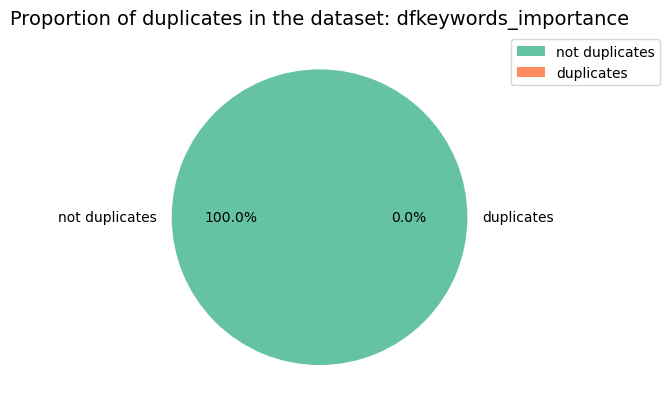

In [15]:
# little fancy visualization for dfconcepts

dfkey_noduplicates = dfkeywords_importance.drop_duplicates()

# data to be displayed
data = [len(dfkey_noduplicates), len(dfkeywords_importance) - len(dfkey_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: dfkeywords_importance",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

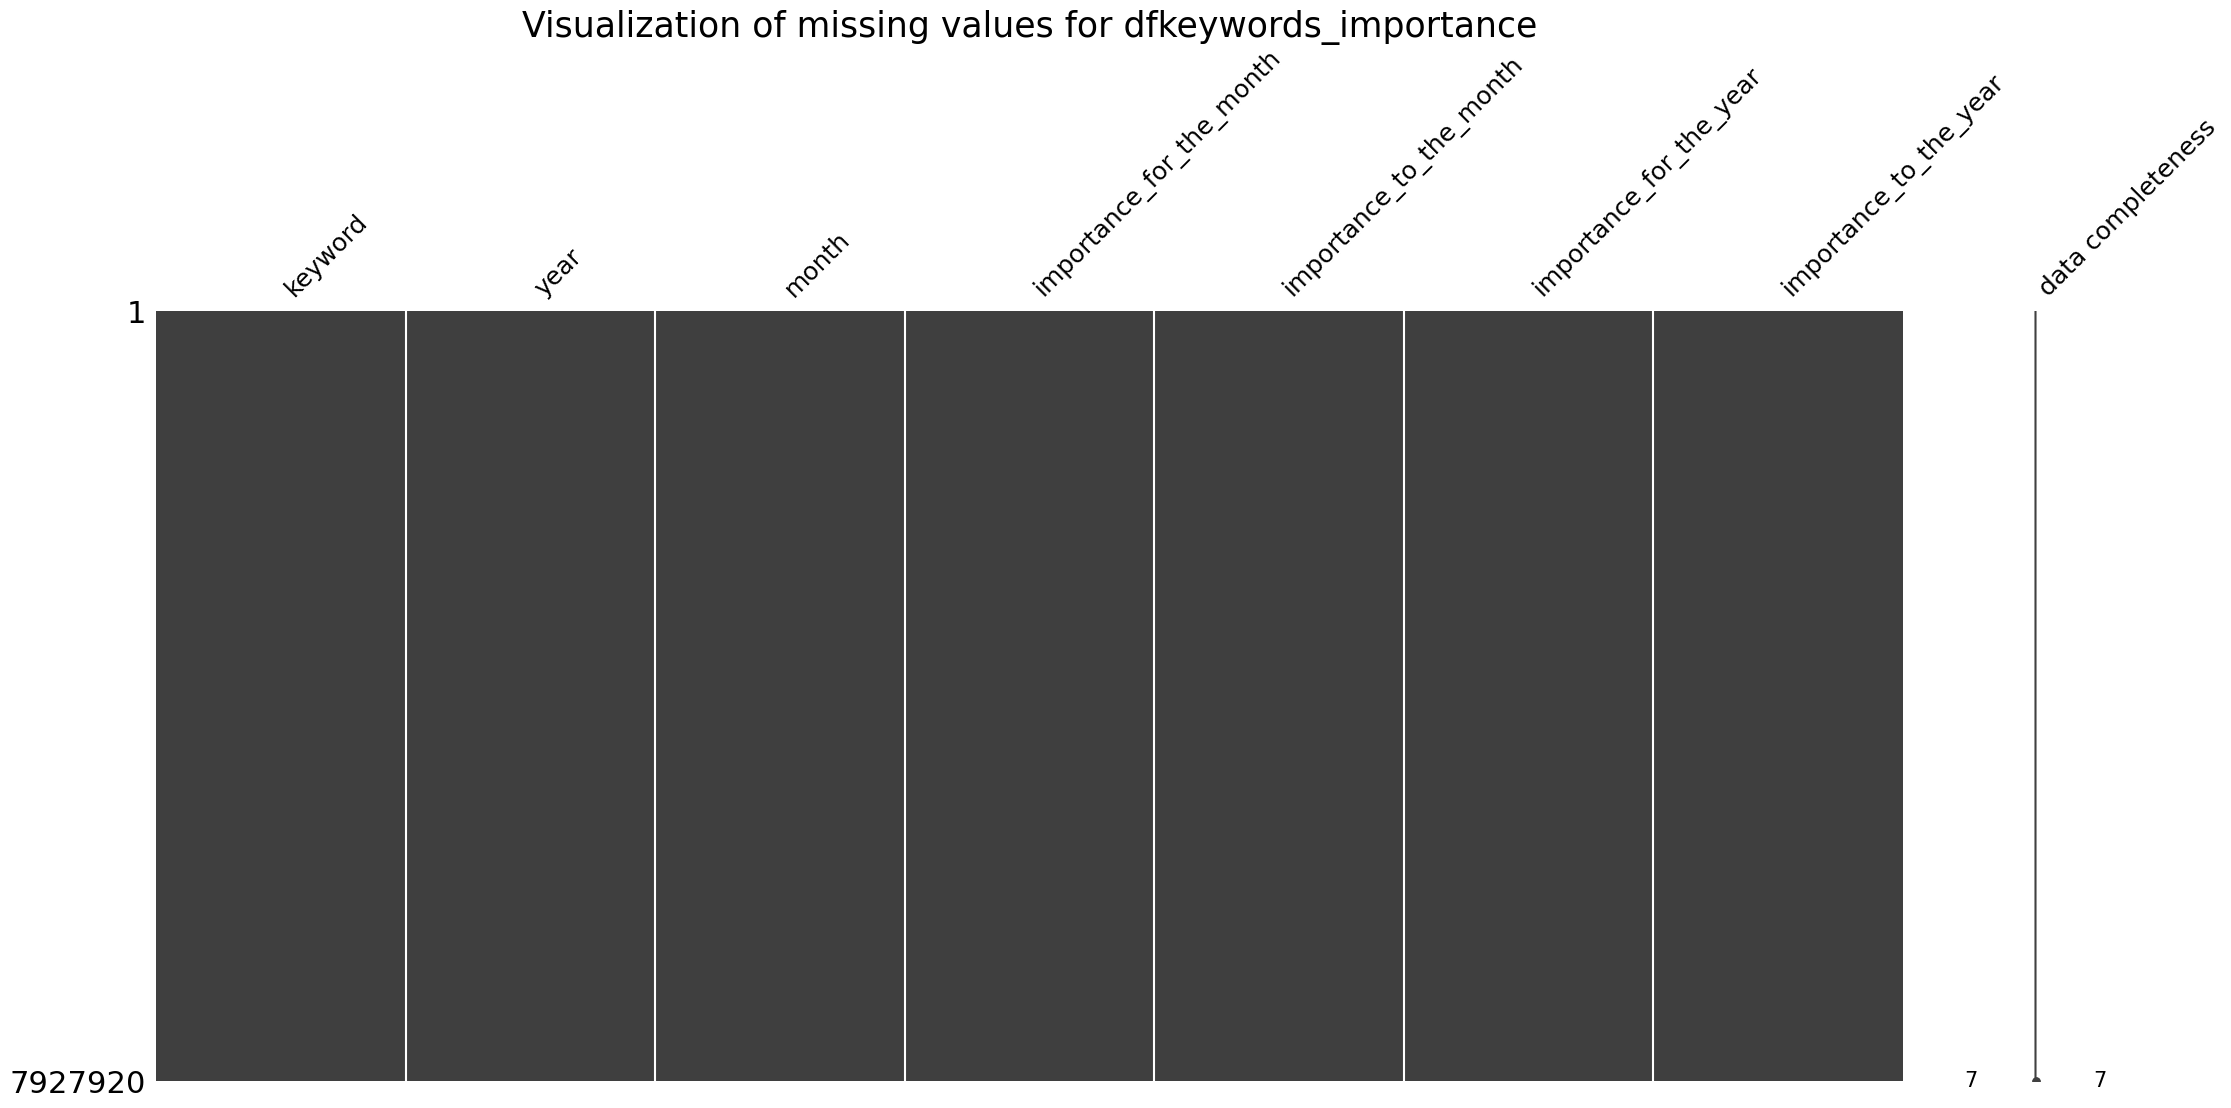

In [16]:
msno.matrix(dfkeywords_importance,labels=True, fontsize=18)
plt.title("Visualization of missing values for dfkeywords_importance",fontsize = 25)
plt.show()

In [17]:
unique_values = dfkeywords_importance.select_dtypes(include="object").nunique()
unique_values

keyword    31460
month         12
dtype: int64

__Observations__

Everything is totally fine in this dataset, as expected.

__Quick analysis of df_average_cosim__

THE DATASET

This dataset contain information for keywords about all the keywords computed from all the papers published from the first of January 2012 to the 31st of December 2022 related to our list of concepts. 

More specifically, the dataset contains the following information for each paper:
- ```keyword```: the keyword we are considering
- ```average_sim```: the average cosine similarity of all the times this keyword appeared to be one keyword of a paper.

In [18]:
infile_df_average_cosim = open('../creation_data_and_variables/data_creation_variables/df_average_cosim','rb')
df_average_cosim = pickle.load(infile_df_average_cosim)
infile_df_average_cosim.close()

In [19]:
df_average_cosim

,keyword,average_sim
0,electrooculograph,0.3575
1,sdta,0.3419
2,wisa,0.2221
3,wds,0.3539
4,cobot,0.4996
...,...,...
31455,kalka,0.3986
31456,computationfair,0.2872
31457,logicreliabilitytheoret,0.4020
31458,bistat,0.1952


In [20]:
df_average_cosim.describe()

,average_sim
count,31460.000000
mean,0.347716
std,0.077881
min,0.014900
25%,0.294254
50%,0.333700
75%,0.388450
max,0.793100


In [21]:
df_average_cosim.dtypes

keyword         object
average_sim    float64
dtype: object

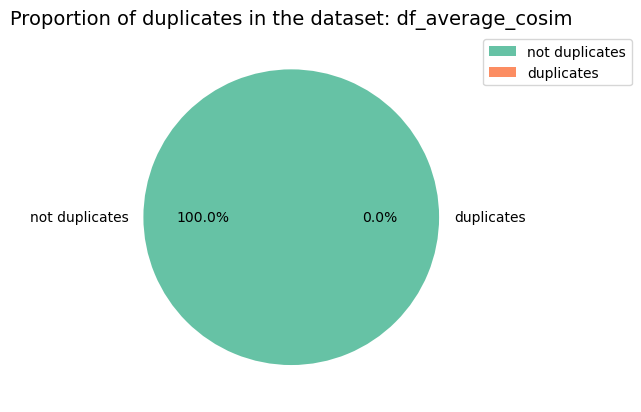

In [22]:
# little fancy visualization for dfconcepts

df_average_cosim_noduplicates = df_average_cosim.drop_duplicates()

# data to be displayed
data = [len(df_average_cosim_noduplicates), len(df_average_cosim) - len(df_average_cosim_noduplicates)]

# labels for radability and intepretation
labels = ["not duplicates", "duplicates"]

# colors
colors = sns.color_palette("Set2")

# creating the pie chart
plt.pie(data, labels=labels, colors=colors, autopct="%0.1f%%")

# title
plt.title(
    "Proportion of duplicates in the dataset: df_average_cosim",
    color="black",  # I am using the 'white' color here, as I am using the 'dark mode' of Jupyter Lab.
    fontsize=14,
)

# legend
plt.legend(bbox_to_anchor=(1, 1))

# calling the pie chart
plt.show()

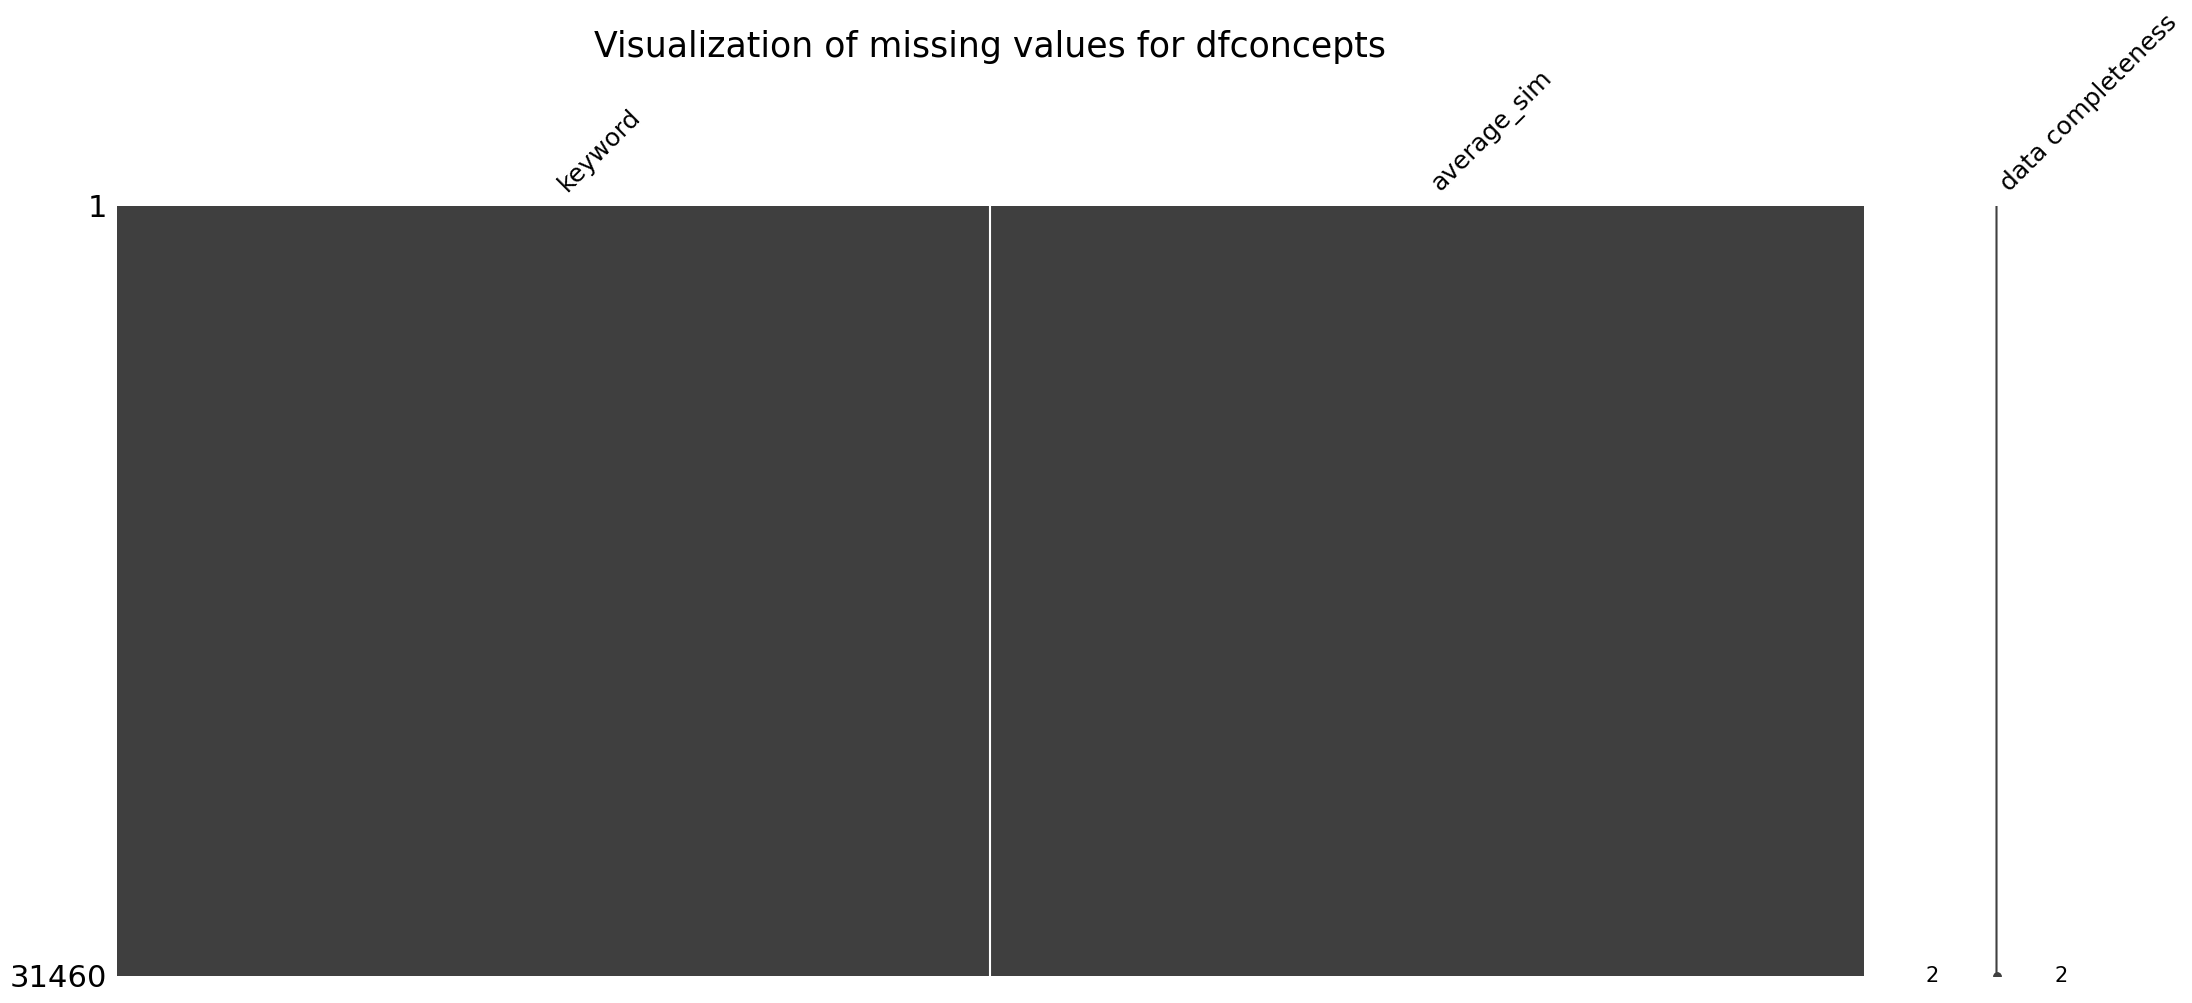

In [23]:
msno.matrix(df_average_cosim,labels=True, fontsize=18)
plt.title("Visualization of missing values for dfconcepts",fontsize = 25)
plt.show()

In [24]:
unique_values = df_average_cosim.select_dtypes(include="object").nunique()
unique_values

keyword    31460
dtype: int64

__Conclusion little analysis of my auxiliairy datasets__

Everything is fine, I have the information I want and my data is cleaned.

<div class="alert-info">
7. More in depth visualization of my data and its features.
</div>

For each year, we show the most important keywords for the field of encryption technologies and some information about them. We also create a dictionary, keeping every word belonging to the the top 10 of each year, and counting how many times, each word arrives in the top 10.

In [25]:
dico_number_times_top10 ={}

my_years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

for year in my_years:
    keywords_year = dfkeywords_importance.loc[dfkeywords_importance['year']==year].copy()
    keywords_year = keywords_year[['keyword','year','importance_for_the_year','importance_to_the_year']]
    keywords_year=keywords_year.drop_duplicates()
    sorted_df = keywords_year.sort_values(by = 'importance_for_the_year', ascending = False)
    print('The most important keywords in the field of encryption technologies for '+str(year)+' are:')
    print(sorted_df.iloc[[0,1,2,3,4,5,6,7,8,9]].keyword.tolist())
    print(' ')
    top10keywords = sorted_df.iloc[[0,1,2,3,4,5,6,7,8,9]].keyword.tolist()
    for word in top10keywords:
        if word not in dico_number_times_top10 :
            dico_number_times_top10[word]=1
        else:
            dico_number_times_top10[word]=dico_number_times_top10[word]+1


The most important keywords in the field of encryption technologies for 2002 are:
['cryptographi', 'protocol', 'cryptograph', 'quantum', 'pki', 'cryptosystem', 'signatur', 'secur', 'algorithm', 'scheme']
 
The most important keywords in the field of encryption technologies for 2003 are:
['cryptosystem', 'cryptograph', 'cryptographi', 'fingerprint', 'pki', 'signatur', 'rsa', 'protocol', 'hash', 'quantum']
 
The most important keywords in the field of encryption technologies for 2004 are:
['fingerprint', 'cryptosystem', 'fpga', 'cryptanalysi', 'pki', 'multicast', 'watermark', 'cryptographi', 'cryptograph', 'protocol']
 
The most important keywords in the field of encryption technologies for 2005 are:
['palmprint', 'watermark', 'signcrypt', 'fpga', 'protocol', 'cryptosystem', 'fingerprint', 'quantum', 'pki', 'cryptanalysi']
 
The most important keywords in the field of encryption technologies for 2006 are:
['rfid', 'watermark', 'cryptograph', 'cryptographi', 'fingerprint', 'cryptosystem',

__Observations__ 

'Crypt', 'hyperellipt', 'rfid' and 'cryptosystem' are words that come up quite often. Nevertheless, the list of the top 10 changes quite often.

We now show the 20 most important keywords over the whole period of time, considering first the number of times a keyword appeared in a top 10 and second the variable 'importance_to_the_year'.

In [26]:
count_top10 = {'keyword':[],'count':[]}

for key, number in dico_number_times_top10.items():
    count_top10['keyword'].append(key)
    count_top10['count'].append(number)
    
df_count_top10 = pd.DataFrame(count_top10)
sorted_df_count = df_count_top10.sort_values(by = 'count', ascending = False)
print('Top 20 of keywords with respect to the count of times belonging to a yearly top 10')
print(sorted_df_count.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]])

mydf = sorted_df_count.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]].copy()
listkeywords1 = mydf.keyword.tolist()

dfkeywords_importance_toshow = dfkeywords_importance[['keyword','year','importance_to_the_year']]
dfkeywords_importance_toshow = dfkeywords_importance_toshow.drop_duplicates()
sorted_df = dfkeywords_importance_toshow.sort_values(by = 'importance_to_the_year', ascending = False)
print('')
print('Top 20 of keywords with respect to importance to the year (in 2022)')
print(sorted_df.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]])

mydf2 = sorted_df.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]].copy()

listkeywords2 = mydf2.keyword.tolist()

listsuperkeywords = [x for x in listkeywords1 if x in listkeywords2]
print('')
print('This keywords occured in the top 20 of both the count and the importance to the year:')
print(listsuperkeywords)

Top 20 of keywords with respect to the count of times belonging to a yearly top 10
              keyword  count
17          palmprint     17
16          watermark     16
19               rfid     15
5        cryptosystem     15
13               fpga     14
10        fingerprint     12
18          signcrypt     12
14       cryptanalysi      9
0        cryptographi      9
28                ecg      8
26              vanet      8
24              voter      6
22              fpgas      6
4                 pki      5
2         cryptograph      5
30  electrocardiogram      5
15          multicast      5
1            protocol      5
3             quantum      5
31                iot      4

Top 20 of keywords with respect to importance to the year (in 2022)
              keyword  year  importance_to_the_year
4747416     palmprint  2022                109.8322
7747728  cryptosystem  2022                108.2791
2195160     watermark  2022                108.1685
6617508  cryptographi  2022    

__Observations__

We see that 14 keywords appear in both top 20, so both indicators ('importance for the year' and 'importance to the year') converge in the end. This list above is the list of the most important keywords for encryption technologies in the last 10 years and it seems reasonable to be so. 

We visualize the keywords with the highest average cosine similarity.

Nevertheless, we first create a dataframe with the count of the number times every keyword appears in my data.

In [27]:
listkeyword = dfkeywords.keyword.tolist()
freqncyDictionary_keywords = Counter(listkeyword)

In [28]:
freqncyDictionary_keywords

Counter({'blockchain': 20087,
         'slave': 4,
         'comput': 5489,
         'mobil': 2647,
         'slaveri': 3,
         'iri': 4205,
         'irid': 25,
         'plenopt': 5,
         'melanoma': 7,
         'micro': 36,
         'pipenet': 1,
         'pipelin': 110,
         'fusion': 1516,
         'spoof': 581,
         'stream': 372,
         'ear': 446,
         'biometr': 7721,
         'shape': 95,
         'identif': 2599,
         'quantum': 9444,
         'hash': 11377,
         'code': 1078,
         'quantiti': 39,
         'constraint': 811,
         'ledger': 1192,
         'chain': 1736,
         'privat': 626,
         'transport': 130,
         'cloud': 4710,
         'audit': 946,
         'outsourc': 517,
         'data': 4348,
         'shacham': 10,
         'easi': 354,
         'access': 1695,
         'technolog': 8380,
         'cryptographi': 12484,
         'cryptosystem': 5831,
         'cryptolog': 119,
         'encrypt': 17262,
         'wo

In [29]:
keywords = []
count = []
for key, values in dict(freqncyDictionary_keywords).items():
    keywords.append(key)
    count.append(values)

In [30]:
dico_freq={'keyword':keywords,'count':count}

In [31]:
dfkeywordcount=pd.DataFrame(dico_freq)

In [32]:
dfkeywordcount.to_pickle('data_exploratory_analysis/dfkeywordcount')

Now, that this dataframe was downloaded, I show the top 20 of keywords, with respect to the highest average cosine similarity.

In [33]:
sorted_df_cosim = df_average_cosim.sort_values(by = 'average_sim', ascending = False)
for i in range(20):
    myinfo = sorted_df_cosim.iloc[[i]].copy()
    keyword = myinfo.keyword.tolist()[0]
    average_sim = myinfo.average_sim.tolist()[0]
    print('The keyword '+str(keyword)+' has an average cosine similarity of '+str(average_sim)+' and occured '+str(freqncyDictionary_keywords[str(keyword)])+' times.')
    print(' ')


The keyword enemi has an average cosine similarity of 0.7931 and occured 1 times.
 
The keyword kryptografi has an average cosine similarity of 0.7906 and occured 1 times.
 
The keyword hemangioma has an average cosine similarity of 0.7766 and occured 1 times.
 
The keyword middlebox has an average cosine similarity of 0.7604 and occured 1 times.
 
The keyword wristconduct has an average cosine similarity of 0.7546 and occured 1 times.
 
The keyword betterauth has an average cosine similarity of 0.7544 and occured 1 times.
 
The keyword vsql has an average cosine similarity of 0.7538 and occured 1 times.
 
The keyword biometrichandprint has an average cosine similarity of 0.7538 and occured 1 times.
 
The keyword histolog has an average cosine similarity of 0.7468 and occured 1 times.
 
The keyword gossam has an average cosine similarity of 0.7463 and occured 1 times.
 
The keyword dlranksvm has an average cosine similarity of 0.7414 and occured 1 times.
 
The keyword watermarkbiometr 

__Observation__

This top 20 does not correspond at all with the top 20 computed before. In fact, these keywords seem to be a little strange and we see that the frequency of the occurence of keywords is at least as important as the cosine similarity. As we saw in the variables 'importance to the year' I created, this allows us to choose only the keywords that are really meaningful.

Last but not least, we visualize the distribution of keywords with respect to cosine similarity, to see how many keywords have a certain cosine similarity and so on.

__Distribution of keywords with respect to cosine similarity__

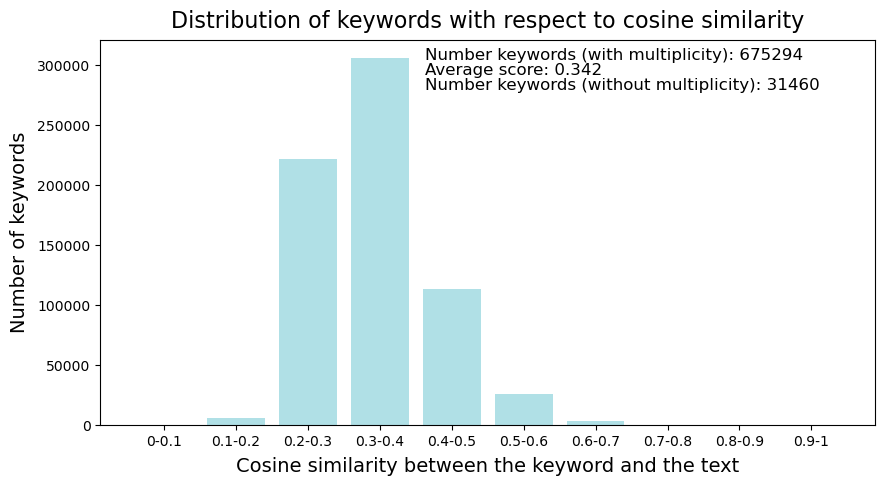

In [35]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

mykeywords = list(set(dfkeywords.keyword.tolist()))

list_cosine_sim = dfkeywords.cosine_similarity.tolist()

numberpapers_bycat = []

for i in range(10):
    specificlist=[x for x in list_cosine_sim if 0.10000000001*(i+1)>x>=i*0.1]
    numberpapers_bycat.append(len(specificlist))

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

# score bar chat
# setting the axes of our horizontal bar plot

x_cor = ['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1']
plt.bar(x_cor, numberpapers_bycat, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Cosine similarity between the keyword and the text",**label_specs)
plt.ylabel("Number of keywords",**label_specs)


# setting the bar plot title
plt.title("Distribution of keywords with respect to cosine similarity",**title_specs)


plt.figtext(0.45, 0.81, "Average score: "+str(round(sum(list_cosine_sim)/len(list_cosine_sim),3)), fontsize=12)
plt.figtext(0.45, 0.84, "Number keywords (with multiplicity): \
"+str(len(list_cosine_sim)), fontsize=12)
plt.figtext(0.45, 0.78, "Number keywords (without multiplicity): \
"+str(len(list(set(dfkeywords.keyword.tolist())))), fontsize=12)
plt.show()

__Observations__

We can see that most of the keywords have a cosine similarity between 0.2 and 0.6. The rest is really rare. We should keep in mind later for the computation of the indices of proximity, that there almost no cosine similarities in the extreme.

We now want to understand how the keywords are distributed with respect to the number of times they occur.

In [36]:
infile_dfkeywordcount = open('data_exploratory_analysis/dfkeywordcount','rb')
dfkeywordcount = pickle.load(infile_dfkeywordcount)
infile_dfkeywordcount.close()

In [37]:
dfkeywordcount

,keyword,count
0,blockchain,20087
1,slave,4
2,comput,5489
3,mobil,2647
4,slaveri,3
...,...,...
31455,belgium,1
31456,fairswap,1
31457,liabl,1
31458,publiccommut,1


In [38]:
dfkeywordcount.rename(columns={"count": "mycount"}, inplace=True)

In [39]:
dfkeywordcount

,keyword,mycount
0,blockchain,20087
1,slave,4
2,comput,5489
3,mobil,2647
4,slaveri,3
...,...,...
31455,belgium,1
31456,fairswap,1
31457,liabl,1
31458,publiccommut,1


In [40]:
max(dfkeywordcount.mycount.tolist())

21352

In [41]:
dfkeywordcount=dfkeywordcount.sort_values(by = 'mycount', ascending = False)

In [42]:
freqncyDictionary_keywords = Counter(dfkeywordcount.mycount.tolist())
freqncyDictionary_keywords

Counter({21352: 1,
         20087: 1,
         17262: 1,
         12484: 1,
         11867: 1,
         11377: 1,
         11121: 1,
         10817: 1,
         9444: 1,
         8380: 1,
         7721: 1,
         6186: 1,
         5831: 1,
         5564: 1,
         5489: 1,
         5005: 1,
         4950: 1,
         4841: 1,
         4838: 1,
         4710: 1,
         4694: 1,
         4348: 1,
         4205: 1,
         4140: 1,
         4136: 1,
         3842: 1,
         3534: 1,
         3417: 1,
         3072: 1,
         3056: 1,
         2903: 1,
         2825: 1,
         2786: 1,
         2777: 1,
         2651: 1,
         2647: 1,
         2634: 1,
         2622: 1,
         2599: 1,
         2510: 1,
         2409: 1,
         2378: 1,
         2102: 1,
         2085: 1,
         2068: 1,
         1976: 2,
         1973: 1,
         1956: 1,
         1859: 1,
         1843: 1,
         1832: 1,
         1812: 1,
         1791: 1,
         1778: 1,
         1736: 1,
  

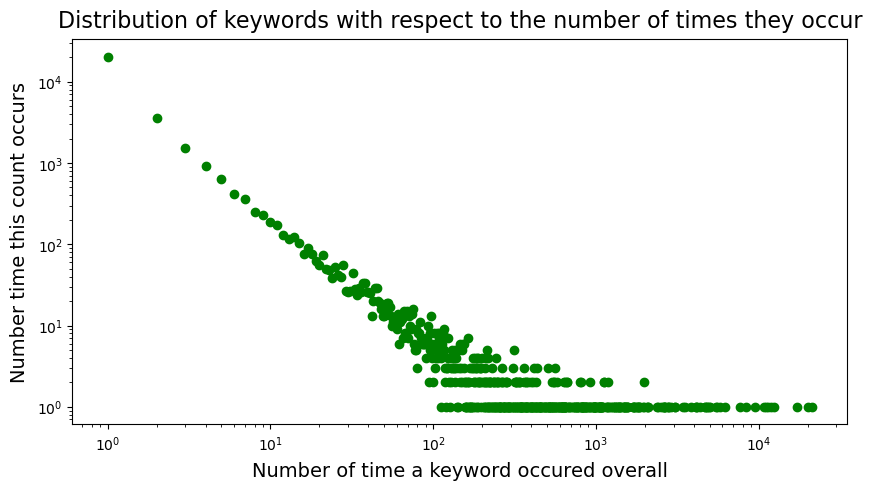

In [43]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

count = list(freqncyDictionary_keywords.keys())
numberoccurence_count = list(freqncyDictionary_keywords.values())  

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.plot(count, numberoccurence_count,'go')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of time a keyword occured overall",**label_specs)
plt.ylabel("Number time this count occurs",**label_specs)
plt.title("Distribution of keywords with respect to the number of times they occur",**title_specs)
plt.show()

__Observations__

We see that there are a lot of keywords that occured only once or twice. For this reason, they might not be proper keywords, because if they would be keywords, they would occur more than once (as keywords) over 90'000 papers. Besides there are many keywords that appeared a lot of times, but whose specific count occured only a few times. This is normal, since a keyword that occured 329 times is not in the same count as a keyword that occured 328 times for example.

We visualize below the same information in bar chart.

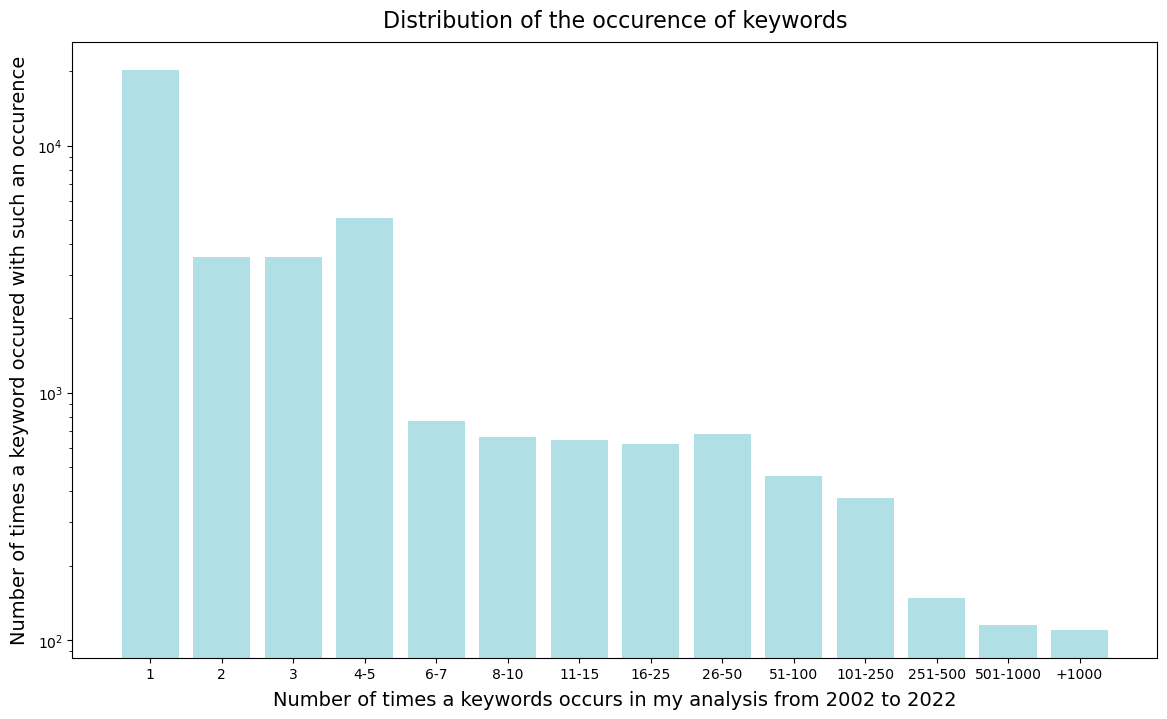

In [45]:
# lables and title specs
label_specs = {"fontsize": 14,"labelpad":6}
title_specs = {"fontsize": 16, "y": 1.01}

steps_sorting= [1,2,3,5,7,10,15,25,50,100,250,500,1000,50000]

x_label= ['1','2','3','4-5','6-7','8-10','11-15','16-25','26-50','51-100','101-250','251-500','501-1000','+1000']

numberkeywords= []

count = list(freqncyDictionary_keywords.keys())
numberoccurence_count = list(freqncyDictionary_keywords.values())  

for i in range(13):
    valuetoadd = 0
    if i <2:
        for onecount in count:
            if onecount==(i+1):
                valuetoadd = valuetoadd+freqncyDictionary_keywords[onecount]
        numberkeywords.append(valuetoadd)
    if i ==2:
        for onecount in count:
            if onecount==2:
                valuetoadd = valuetoadd+freqncyDictionary_keywords[onecount]
        numberkeywords.append(valuetoadd)
        for onecount in count:
            if 5>=onecount>3:
                valuetoadd = valuetoadd+freqncyDictionary_keywords[onecount]
        numberkeywords.append(valuetoadd)
    if i>2 :
        above = steps_sorting[i+1]
        below =steps_sorting[i]
        for onecount in count:
            if above>=onecount>below:
                valuetoadd = valuetoadd+freqncyDictionary_keywords[onecount]
        numberkeywords.append(valuetoadd)


f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)

# score bar chat
# setting the axes of our horizontal bar plot

plt.bar(x_label, numberkeywords, color="powderblue")  
# setting the column of our dataset ('number of papers') that we want to plot as a numerical variable

# setting the labels of our axes
plt.xlabel("Number of times a keywords occurs in my analysis from 2002 to 2022",**label_specs)
plt.ylabel("Number of times a keyword occured with such an occurence",**label_specs)

plt.yscale('log')
# to see something, because, without that we do not see anything!

# setting the bar plot title
plt.title("Distribution of the occurence of keywords",**title_specs)

# showing the bar plot (command not necessary, but it avoids to print the explanation text)
plt.show()

__Observations__

This bar chart is in log scale (for the y-axis) and we see that there is a huge amount of keywords that occured less than 5 times, while not many keywords occured more than 1000 times (20 approximatively).

<div class="alert-info">
8. Correlation analysis
</div>

We visualize one more time our data below. Clearly, it would not be possible, to transform ```keywords``` or ```paper``` into categorical data, since there are too many different papers and keywords. For this reason, the only possibly correlated information we visualize is the one between ```cosine_similarity``` and ```year```and ```month```.

In [46]:
dfkeywords

,paper,keyword,cosine_similarity,publication_date,year,month
0,https://openalex.org/W2885223756,blockchain,0.4387,2018-08-16,2018,August
0,https://openalex.org/W2885223756,slave,0.3483,2018-08-16,2018,August
0,https://openalex.org/W2885223756,comput,0.3407,2018-08-16,2018,August
0,https://openalex.org/W2885223756,mobil,0.334,2018-08-16,2018,August
0,https://openalex.org/W2885223756,slaveri,0.3331,2018-08-16,2018,August
...,...,...,...,...,...,...
135447,https://openalex.org/W4214588288,neural,0.3529,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synthet,0.3373,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synthesi,0.3073,2021-10-01,2021,October
135447,https://openalex.org/W4214588288,synfac,0.3009,2021-10-01,2021,October


Creating a heat map with the values about the cosine similarity using the function sum.

In [47]:
from pandas.api.types import CategoricalDtype

my_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

cat_dtype = CategoricalDtype(
    categories=my_months, ordered=True)
dfkeywords['month']=dfkeywords['month'].astype(cat_dtype)

In [48]:
dfkeywords['cosine_similarity']=dfkeywords['cosine_similarity'].astype(float)

In [49]:
heatmap_data = pd.pivot_table(
    dfkeywords, values="cosine_similarity", index="month", columns="year", aggfunc=np.sum
)
heatmap_data

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
January,31.7139,151.9698,282.7368,360.3521,559.1746,613.8634,520.4196,693.0380,692.9549,849.6736,...,961.5289,1156.1615,1056.7492,907.2583,1035.9805,1381.8132,1815.8482,2049.2509,2205.0140,1271.0320
February,35.2477,88.5650,151.0285,263.1736,284.1216,288.9780,371.8399,468.3705,522.4706,554.5288,...,759.6955,717.0247,807.4703,681.2870,542.3340,727.3272,909.4318,1255.3951,1782.4299,1106.2977
March,25.1519,56.9696,230.7028,330.5226,368.2975,369.3484,599.8040,676.1340,644.7883,766.7727,...,815.2476,1031.2369,942.3733,989.2630,849.3914,861.9571,1190.9926,1398.6627,2135.5204,1474.6497
April,26.9087,123.9038,203.5132,309.6883,517.5119,528.1581,638.8601,716.4231,803.7412,756.1480,...,935.9469,838.4019,1083.5703,749.0056,889.4190,1028.4626,1262.7479,1360.0780,2003.9818,1512.6387
May,26.7320,127.8512,317.3727,405.9801,478.2688,532.9677,595.8577,820.2912,804.8816,822.5695,...,1038.5274,1185.3044,1129.0499,911.7908,1001.3642,1157.6886,1429.5266,1515.8483,2386.9846,1695.8406
June,42.1727,162.2711,286.7089,349.3575,398.4699,673.5433,679.4170,985.6808,958.6771,980.0785,...,1203.0357,1143.6694,1043.9319,842.4352,1042.8082,1273.2727,1647.5405,1847.5523,2263.2073,1579.9335
July,45.3690,146.6224,218.7888,452.0252,393.9795,629.4099,524.2764,699.5166,859.6223,891.0140,...,1101.3567,930.6923,1004.7448,955.5620,1040.6146,1368.4039,1862.7702,1800.6469,2261.9162,1346.2116
August,56.1861,138.5817,313.7761,376.2069,552.9849,707.3789,574.9409,797.2799,792.4548,744.5293,...,879.6498,1016.0191,1110.4862,1103.5490,1006.1132,1120.0403,1308.3581,1444.3760,2023.8219,1363.6568
September,57.0294,187.6558,276.5376,435.6333,615.2154,595.8610,626.2062,932.3280,830.8494,854.6798,...,1230.9787,1237.6164,1086.4727,1078.9726,1016.8139,1193.1354,1582.4713,1919.3170,2264.4854,1657.3980


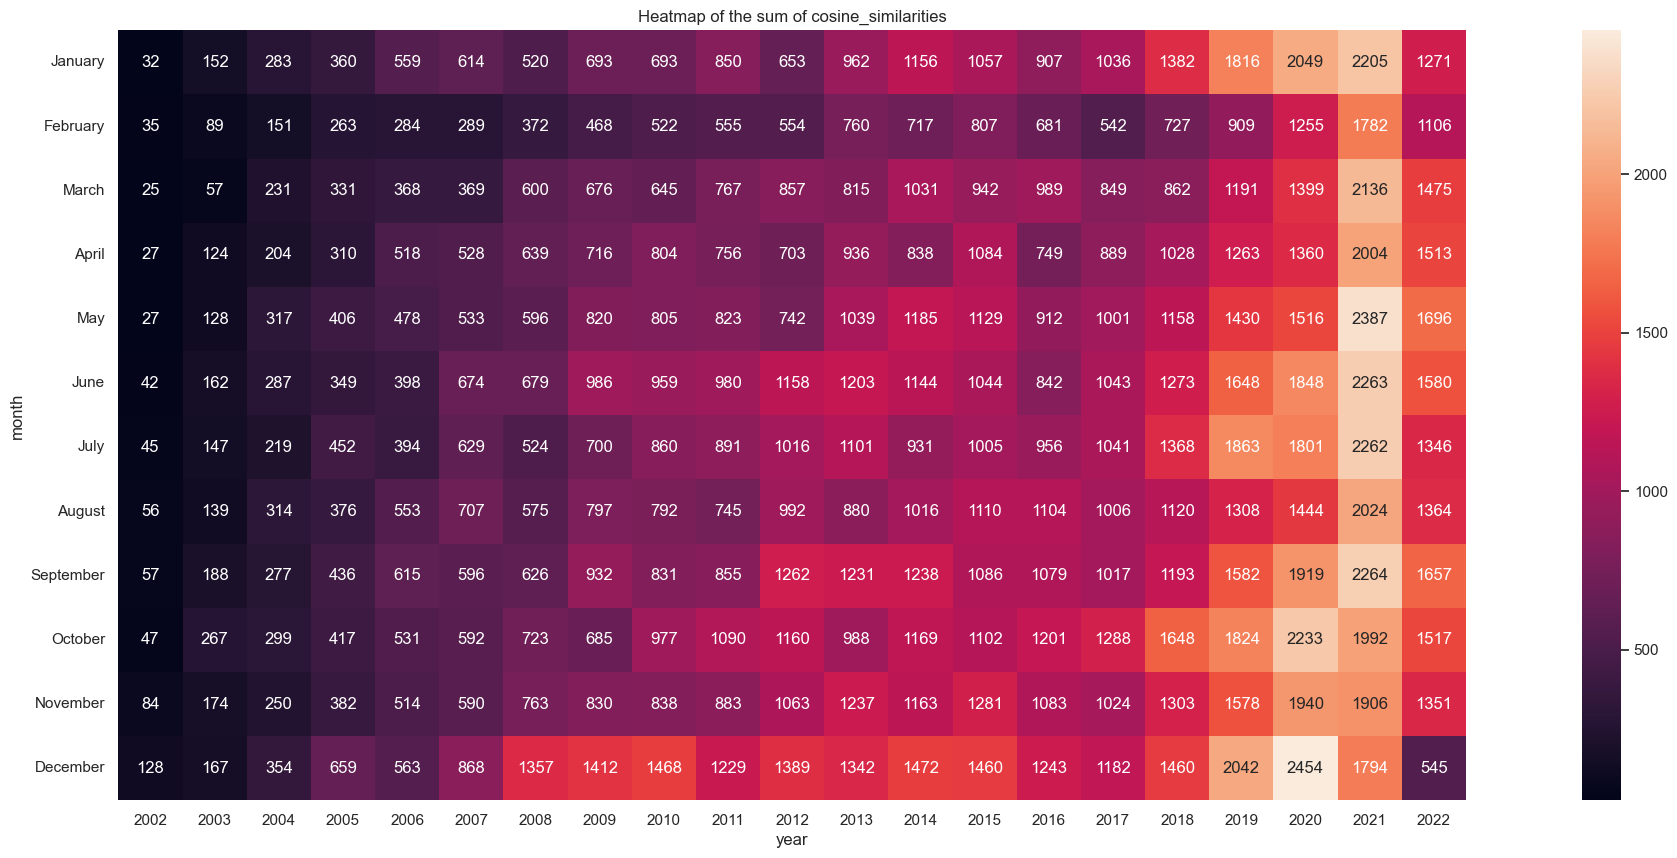

In [50]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.heatmap(heatmap_data, annot=True, square=True, fmt=".0f").set(
    title="Heatmap of the sum of cosine_similarities"
)
plt.show()

__Observations__

We see that with time, the sum of the cosine similarities increases. But this is just due to the fact, that there are always more and more papers produced and therefore more occurences of keywords and so on. Besides, we see that there are less papers in November and December 2022, but this is just due to the fact that we do not have all information yet about these months.

Creating a heat map with the values about the cosine similarity using the function mean.

In [51]:
heatmap_data = pd.pivot_table(
    dfkeywords, values="cosine_similarity", index="month", columns="year", aggfunc=np.mean
)
heatmap_data

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
January,0.360385,0.350161,0.348198,0.347160,0.347962,0.349382,0.342832,0.351617,0.343387,0.344276,...,0.343894,0.339448,0.338593,0.344441,0.348580,0.347364,0.354589,0.354480,0.349725,0.345953
February,0.352477,0.354260,0.348796,0.355160,0.355152,0.351128,0.345255,0.342376,0.341261,0.339369,...,0.339150,0.341440,0.339701,0.339117,0.338959,0.340190,0.335956,0.340308,0.345031,0.341029
March,0.335359,0.345270,0.342798,0.342510,0.342602,0.343261,0.343334,0.345142,0.339899,0.336895,...,0.345884,0.345821,0.340822,0.336942,0.337462,0.338288,0.342043,0.341054,0.344717,0.344867
April,0.340616,0.350011,0.349079,0.343716,0.342496,0.341187,0.342002,0.343279,0.341002,0.339689,...,0.340592,0.339022,0.339464,0.337846,0.341690,0.341682,0.340547,0.339087,0.342561,0.348454
May,0.334150,0.350277,0.340529,0.345515,0.342109,0.344963,0.345625,0.341361,0.343233,0.339344,...,0.339388,0.339434,0.339360,0.337450,0.338184,0.340296,0.339797,0.339040,0.341828,0.344123
June,0.345678,0.352763,0.343364,0.349707,0.346195,0.346651,0.340731,0.341776,0.342018,0.339010,...,0.341287,0.336077,0.336970,0.334964,0.339235,0.338726,0.341955,0.340061,0.337440,0.347238
July,0.346328,0.353307,0.340263,0.340124,0.346203,0.345640,0.340882,0.346639,0.343437,0.348324,...,0.336189,0.335022,0.338184,0.333413,0.335466,0.341163,0.341104,0.341032,0.339423,0.347858
August,0.351163,0.359952,0.343676,0.350286,0.341982,0.341234,0.345517,0.342769,0.344396,0.343259,...,0.340290,0.343250,0.340431,0.338304,0.340824,0.341788,0.340541,0.341218,0.340711,0.341170
September,0.360946,0.361572,0.348723,0.354750,0.346796,0.342056,0.343503,0.345179,0.344894,0.347572,...,0.345102,0.344932,0.343061,0.339193,0.338487,0.338863,0.340536,0.340546,0.340064,0.341099


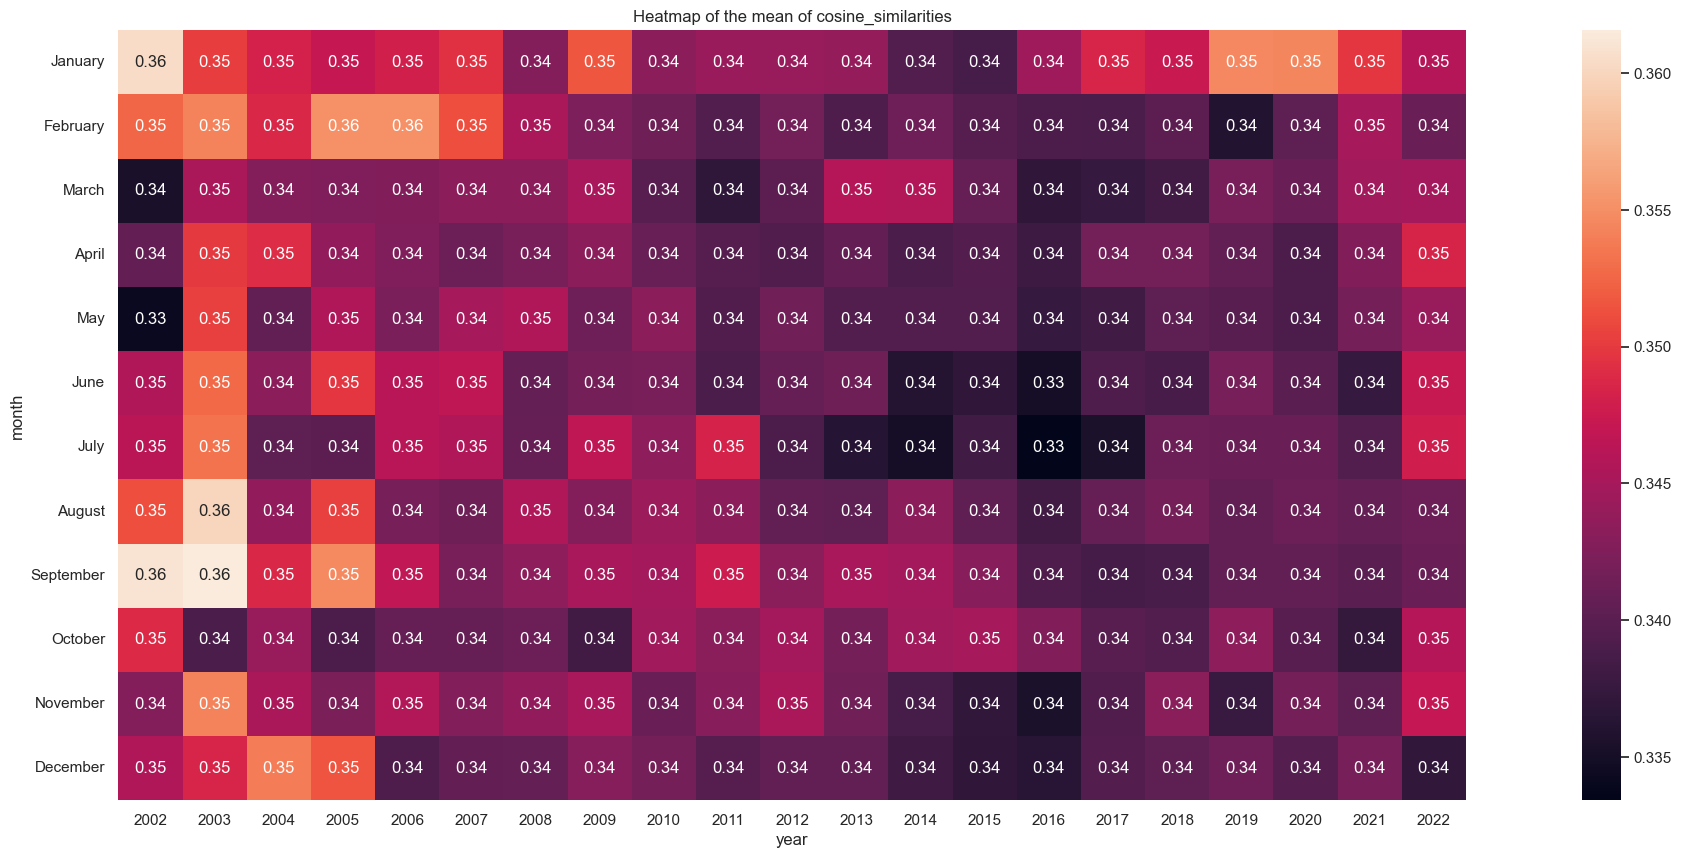

In [52]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.heatmap(heatmap_data, annot=True, square=True).set(
    title="Heatmap of the mean of cosine_similarities"
)
plt.show()

__Observations__

Clearly the mean is very stable. Just in 2012 we have the minimum and the maximum over all the dataset, but this is just due to the fact, that there were less papers, and therefore less papers to compensate extreme values.

We now plot the correlation of the data between the different variables using _seaborn.pairplot_.

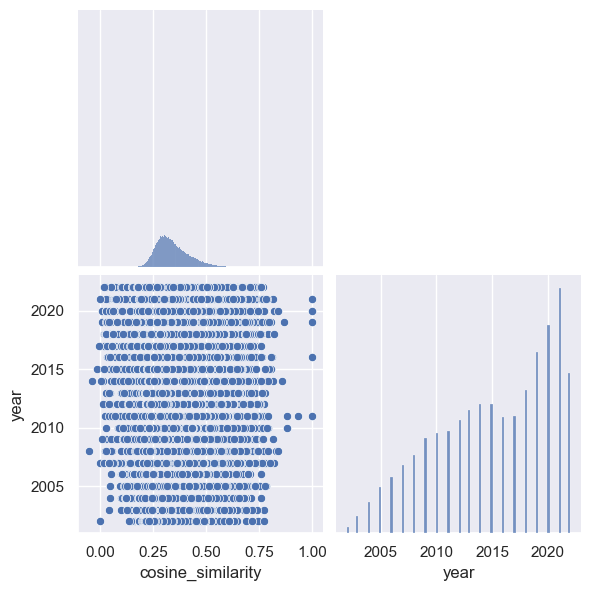

In [53]:
sns.pairplot(dfkeywords, height=3,corner=True)
plt.show()

__Observations__

One can see that the cosine similarities are almost normally distributed from 0 to 1, the y-scale of the distribution is not shown, but one can understand that it is rescaled because of some parameters. The range of cosine similarities increases a bit with time, but this is negligible. On the low corner right, we see that the amount of published paper increases greatly with time.

In [54]:
dfkeywords.corr()

,cosine_similarity,year
cosine_similarity,1.0000,-0.0089
year,-0.0089,1.0000


In [55]:
corr_df = pd.DataFrame(np.tril(dfkeywords.corr()))

In [56]:
corr_df_lowtriangular = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool))

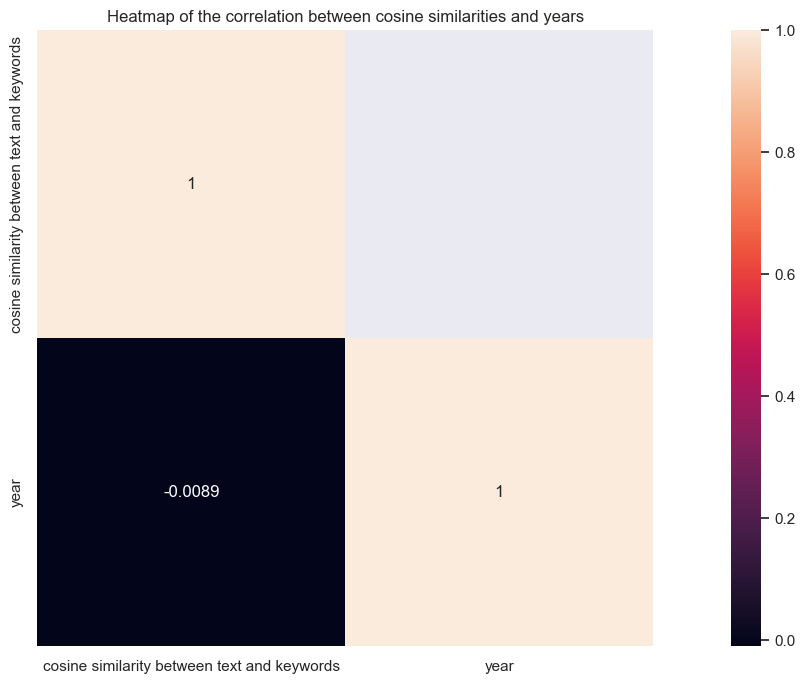

In [58]:
sns.set(rc={"figure.figsize": (20, 8)})
sns.heatmap(corr_df_lowtriangular, annot=True, square=True).set(
title="Heatmap of the correlation between cosine similarities and years",
xticklabels=['cosine similarity between text and keywords','year'],
yticklabels=['cosine similarity between text and keywords','year']
)
plt.show()

__Observation__

As expected, the variables ```year``` and ```cosine_similarity``` are not correlated.